In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
sns.set()
import tensorflow as tf
import sys
sys.path.append('..')

In [3]:
from stonks.DataCatcher import DB
from stonks.auxiliary.data_preprocessing import make_x_y

In [7]:
db = DB()

In [8]:
start = (datetime.datetime(2020, 3, 23) - datetime.datetime(1970,1,1)).total_seconds()
end = (datetime.datetime(2020, 3, 30) - datetime.datetime(1970,1,1)).total_seconds()
week_data = db.fetch_pandas(start, end, {'btcusdt'})

data = week_data.copy()

In [9]:
target = (week_data['depth_bid_price_1'] + week_data['depth_ask_price_1']) / 2.
target.index = week_data['time'].apply(datetime.datetime.fromtimestamp)

In [41]:
from stonks.auxiliary.data_preprocessing import basic_clean, get_kline_info, construct_order_names, get_state_fast
from stonks.auxiliary.data_preprocessing import count_some, rolling, plot_state

In [12]:
data = basic_clean(data)

In [13]:
orders = data[construct_order_names(5)]
some = count_some(orders, 5)
some.drop(construct_order_names(5), axis=1, inplace=True)

In [14]:
some.drop('mid_price', axis=1, inplace=True)

In [18]:
kline_cols = []
for el in data.columns:
    if 'kline_' in el:
        kline_cols.append(el)

In [21]:
klines = data[kline_cols]
klines.head()

,kline_trade_number,kline_open_price,kline_close_price,kline_high_price,kline_low_price,kline_base_volume,kline_quote_volume,kline_taker_base_volume,kline_taker_quote_volume,kline_time_since_update,kline_update_time
normal_time,,,,,,,,,,,
2020-03-23 03:00:00.118062,604,5816.79,5816.19,5828.57,5813.0,95.30708,554568.084893,31.87913,185457.192356,60116.780029,1.584922e+12
2020-03-23 03:00:01.260521,604,5816.79,5816.19,5828.57,5813.0,95.30708,554568.084893,31.87913,185457.192356,1259.923096,1.584922e+12
2020-03-23 03:00:02.658440,604,5816.79,5816.19,5828.57,5813.0,95.30708,554568.084893,31.87913,185457.192356,2652.394775,1.584922e+12
2020-03-23 03:00:04.553246,604,5816.79,5816.19,5828.57,5813.0,95.30708,554568.084893,31.87913,185457.192356,4551.988281,1.584922e+12
2020-03-23 03:00:05.798263,604,5816.79,5816.19,5828.57,5813.0,95.30708,554568.084893,31.87913,185457.192356,5797.824219,1.584922e+12


In [22]:
klines.drop('kline_update_time', axis=1, inplace=True)
klines['kline_delta'] = klines['kline_close_price'] - klines['kline_open_price']
klines['kline_volatility'] = klines['kline_high_price'] - klines['kline_low_price']

In [23]:
kline_id = 0


def get_id(x):
    global kline_id
    if x:
        kline_id += 1
    return x * kline_id

In [25]:
global kline_id
kline_id = 0

shifted_update = klines['kline_time_since_update'].shift(1)
klines['new_kline'] = klines['kline_time_since_update'] < shifted_update

klines['kline_id'] = klines['new_kline'].apply(get_id)

klines['kline_id'].replace({0: np.NaN}, inplace=True)
klines['kline_id'].ffill(inplace=True)

klines.dropna(inplace=True)
klines.drop('new_kline', axis=1, inplace=True)
off = klines[['kline_id', 'kline_trade_number', 'kline_open_price', 'kline_close_price',
                   'kline_high_price', 'kline_low_price', 'kline_base_volume',
                   'kline_quote_volume', 'kline_taker_base_volume',
                   'kline_taker_quote_volume', 'kline_time_since_update']].groupby(
        'kline_id').mean()

In [40]:
state = get_state_fast(off['kline_close_price'].reset_index(drop=True), 0.001)
state.index = off.index

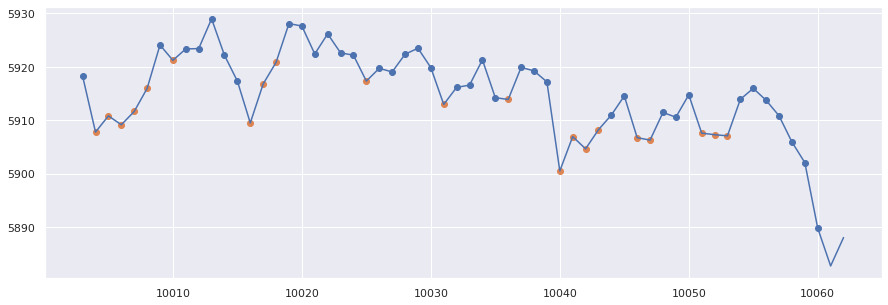

In [46]:
plt.figure(figsize=(15, 5))
off1 = off.iloc[-60:]
plt.plot(off1.index, off1['kline_close_price'])
plt.scatter(off1[state == 0].index, off1[state == 0]['kline_close_price'])
plt.scatter(off1[state == 1].index, off1[state == 1]['kline_close_price'])

### Что насчет LSTM?

In [47]:
from sklearn.preprocessing import StandardScaler

x = off.copy()
y = state

scaler = StandardScaler()
scaler.fit(x)
x = pd.DataFrame(scaler.transform(x), index=x.index, columns=x.columns)

x = x[y != -1]
y = y[y != -1]

In [50]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

y_cat = tf.keras.utils.to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(x, y_cat, shuffle=False)
y_not = y_test[:,1]

train_gen = TimeseriesGenerator(X_train.values, y_train, 60, batch_size=64, shuffle=True)
val_gen = TimeseriesGenerator(X_test.values, y_test, 60, batch_size=64)

In [57]:
model = tf.keras.Sequential(name='model')
model.add(tf.keras.layers.LSTM(64, input_shape=(None, 10)))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                19200     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 34        
Total params: 21,842
Trainable params: 21,842
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.fit_generator(train_gen, epochs=10)

W0410 18:34:54.422444 140681546692416 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 117 steps
Epoch 1/10
117/117 [==============================] - 3s 25ms/step - loss: 0.6898 - accuracy: 0.5306
Epoch 2/10
117/117 [==============================] - 3s 25ms/step - loss: 0.6894 - accuracy: 0.5343
Epoch 3/10
117/117 [==============================] - 3s 26ms/step - loss: 0.6886 - accuracy: 0.5369
Epoch 4/10
117/117 [==============================] - 3s 26ms/step - loss: 0.6874 - accuracy: 0.5414
Epoch 5/10
117/117 [==============================] - 3s 26ms/step - loss: 0.6884 - accuracy: 0.5299
Epoch 6/10
117/117 [==============================] - 3s 28ms/step - loss: 0.6859 - accuracy: 0.5419
Epoch 7/10
117/117 [==============================] - 3s 25ms/step - loss: 0.6852 - accuracy: 0.5482
Epoch 8/10
117/117 [==============================] - 3s 24ms/step - loss: 0.6841 - accuracy: 0.5505
Epoch 9/10
117/117 [==============================] - 3s 26ms/step - loss: 0.6853 - accuracy: 0.5494
Epoch 10/10
117/117 [==============================] - 3s 25ms/step - l

In [63]:
proba = model.predict_generator(val_gen)
probas = pd.DataFrame(proba, columns=['goes_down', 'goes_up'])
y_pred = (probas['goes_up'] > probas['goes_down']).apply(int)
y_pred.value_counts()

1    1308
0    1147
dtype: int64

In [69]:
from sklearn.metrics import accuracy_score, roc_auc_score
from stonks.auxiliary.model_selection import choose_prob, plot_predictions
y_not = y_test[:,1]
print(accuracy_score(y_not[60:], y_pred), roc_auc_score(y_not[60:], y_pred))
choose_prob(y_test[60:], probas, 100)

0.4912423625254583 0.49372957873611484
Probabilities: (0.5, 0.5)
Precision: 0.45565749235474007


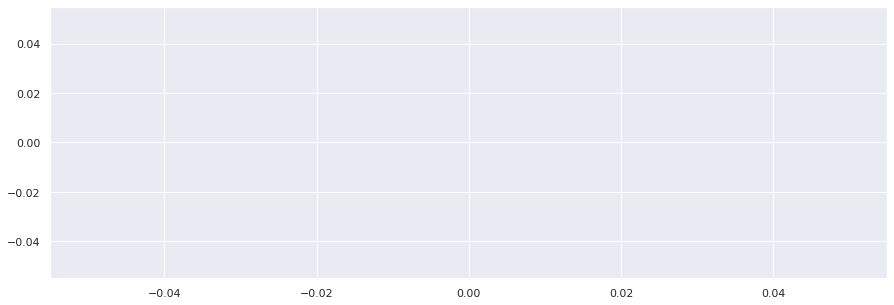

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

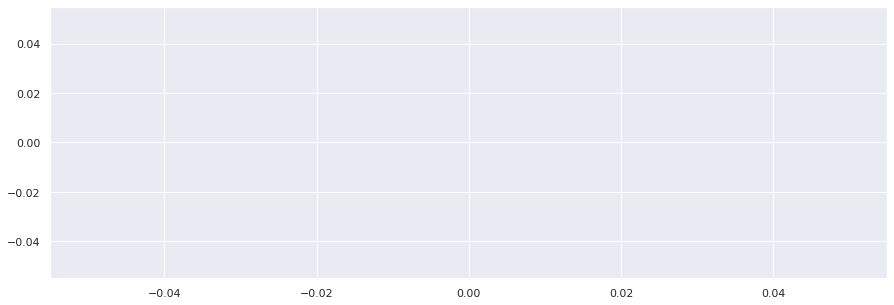

In [74]:
X_test

,kline_trade_number,kline_open_price,kline_close_price,kline_high_price,kline_low_price,kline_base_volume,kline_quote_volume,kline_taker_base_volume,kline_taker_quote_volume,kline_time_since_update
kline_id,,,,,,,,,,
7546.0,0.104722,-0.973798,-0.989704,-0.988082,-0.969677,-0.437376,-0.450397,-0.457657,-0.466605,-0.072936
7547.0,0.284096,-0.989702,-0.949049,-0.960792,-0.968285,-0.352365,-0.368671,-0.259435,-0.276839,-0.048745
7548.0,0.126515,-0.949085,-0.943664,-0.961932,-0.938701,-0.412411,-0.426178,-0.336986,-0.350911,-0.057755
7549.0,0.342770,-0.953222,-0.943736,-0.889144,-0.938345,0.352697,0.309953,0.798699,0.738151,-0.077999
7550.0,-0.121591,-0.943736,-0.941953,-0.948714,-0.924070,-0.501472,-0.511638,-0.479013,-0.486767,-0.067169
...,...,...,...,...,...,...,...,...,...,...
10056.0,-0.476986,-1.838775,-1.845202,-1.847283,-1.825752,-0.256210,-0.292917,-0.285165,-0.315431,-0.056250
10057.0,-0.351257,-1.845407,-1.855544,-1.856440,-1.838813,-0.379816,-0.407075,-0.194695,-0.232605,-0.072008
10058.0,-0.419989,-1.852325,-1.873054,-1.872401,-1.866006,-0.427125,-0.450854,-0.420727,-0.440283,-0.076570


In [73]:
probas

,goes_down,goes_up
0,0.495173,0.504827
1,0.469550,0.530450
2,0.466228,0.533772
3,0.628538,0.371462
4,0.597909,0.402091
...,...,...
2450,0.585371,0.414629
2451,0.583961,0.416039
2452,0.584786,0.415214
2453,0.586384,0.413616


In [ ]:
plt.figure(figsize=(15, 5))
off1 = X_test[60:]
plt.plot(off1.index, off1['kline_close_price'])
plt.scatter(off1[].index, off1[state == 0]['kline_close_price'])
plt.scatter(off1[state == 1].index, off1[state == 1]['kline_close_price'])